In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<ipython-input-1-ac09909db896>:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
! pip install pandas

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data_path = '../LBLS160/data/'

In [5]:
br_pd = pd.read_csv(data_path + 'br.csv')
score_pd = pd.read_csv(data_path+'score.csv')
sill_pd = pd.read_csv(data_path+'sill.csv')
viscode_pd = pd.read_csv(data_path+'viscode.csv')
srl_m_pd = pd.read_csv(data_path+'srl_motivation.csv')

In [6]:
score_pd = score_pd.set_index('userid')
sill_pd = sill_pd.set_index('userid')
viscode_pd = viscode_pd.set_index('userid')
br_pd = br_pd.set_index('userid')
srl_m_pd = srl_m_pd.set_index('userid')

In [7]:
srl_m_pd = srl_m_pd[~srl_m_pd.index.duplicated()]

# merged_pd = pd.concat([br_pd, sill_pd, viscode_pd, score_pd], axis=1)
# merged_pd = pd.concat([br_pd, viscode_pd, srl_m_pd, sill_pd, score_pd], axis=1)
# merged_pd = pd.concat([srl_m_pd, sill_pd, score_pd], axis=1)
merged_pd = pd.concat([srl_m_pd, br_pd, viscode_pd, score_pd], axis=1)
# merged_pd = merged_pd.drop(columns=['REGIST CONTENTS'])

merged_pd = merged_pd[merged_pd['score'].notna()]
merged_pd = merged_pd.fillna(0)

In [8]:
merged_pd['label']=1
merged_pd.loc[merged_pd['score'] > 83, 'label']=0
merged_pd.shape


(198, 85)

# Normalizer

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))

In [11]:

source_class = 'a'

test_list = merged_pd['class'].unique().tolist()
test_list.remove(source_class)
test_list

['b', 'c', 'd']

In [12]:
train_df = merged_pd[merged_pd['class'] == source_class]
test_0_df = merged_pd[merged_pd['class'] == test_list[0]]
test_1_df = merged_pd[merged_pd['class'] == test_list[1]]
test_2_df = merged_pd[merged_pd['class'] == test_list[2]]

train_np = scaler.fit_transform(train_df.drop(['class', 'label', 'score'], axis=1))
test_0_np = scaler.transform(test_0_df.drop(['class', 'label', 'score'], axis=1))
test_1_np = scaler.transform(test_1_df.drop(['class', 'label', 'score'], axis=1))
test_2_np = scaler.transform(test_2_df.drop(['class', 'label', 'score'], axis=1))

In [13]:
# convert from np to df, for feature selection

train_y = train_df['label']
test_0_y = test_0_df['label']
test_1_y = test_1_df['label']
test_2_y = test_2_df['label']

feature_list = list(train_df.drop(['class', 'label', 'score'], axis=1))

train_x_df = pd.DataFrame(train_np, columns = feature_list, index=train_df.index)
test_0_x_df = pd.DataFrame(test_0_np, columns = feature_list, index=test_0_df.index)
test_1_x_df = pd.DataFrame(test_1_np, columns = feature_list, index=test_1_df.index)
test_2_x_df = pd.DataFrame(test_2_np, columns = feature_list, index=test_2_df.index)

# Feature Selection

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [15]:
selector = SelectKBest(score_func=chi2, k=15)

In [16]:
x_new = selector.fit_transform(train_x_df, 
                               train_y)

filter = selector.get_support()

features = np.array(list(train_x_df))

selected_features = list(features[filter])
selected_features

['srl_m_17',
 'srl_m_19',
 'srl_m_22',
 'srl_m_23',
 'srl_m_24',
 'srl_m_25',
 'srl_m_26',
 'ADD MEMO',
 'CHANGE MEMO',
 'DELETE MARKER',
 'NOTGETIT',
 'PAGE_JUMP',
 'code_copy',
 'FileNotFoundError',
 'ModuleNotFoundError']

In [17]:
merged_pd = merged_pd[selected_features]

In [18]:
train_x_df = train_x_df[selected_features]
test_0_x_df = test_0_x_df[selected_features]
test_1_x_df = test_1_x_df[selected_features]
test_2_x_df = test_2_x_df[selected_features]

In [19]:
# train_x_df

# PCA

In [20]:
# from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

In [21]:
pca = PCA(n_components=2)

In [22]:
pca.fit(train_x_df)
train_x_pca_np = pca.transform(train_x_df)
test_0_x_pca_np = pca.transform(test_0_x_df)
test_1_x_pca_np = pca.transform(test_1_x_df)
test_2_x_pca_np = pca.transform(test_2_x_df)

In [23]:
train_pca_pd = pd.DataFrame(train_x_pca_np, index=train_x_df.index)
train_pca_pd['label'] = train_y

test_0_pd = pd.DataFrame(test_0_x_pca_np, index=test_0_df.index)
test_0_pd['label'] = test_0_y

test_1_pd = pd.DataFrame(test_1_x_pca_np, index=test_1_df.index)
test_1_pd['label'] = test_1_y

test_2_pd = pd.DataFrame(test_2_x_pca_np, index=test_2_df.index)
test_2_pd['label'] = test_2_y

# Plot

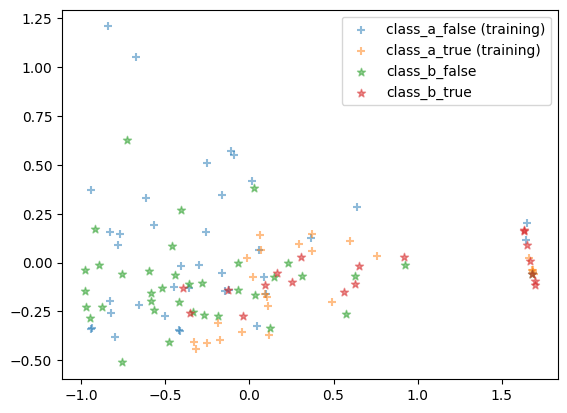

In [24]:
fig, ax = plt.subplots()

plt.scatter(x = train_pca_pd[train_pca_pd['label']==0][0], 
            y = train_pca_pd[train_pca_pd['label']==0][1],
            label = 'class_'+source_class + '_false (training)',
            alpha=0.5, marker="+")

plt.scatter(x = train_pca_pd[train_pca_pd['label']==1][0], 
            y = train_pca_pd[train_pca_pd['label']==1][1],
            label = 'class_'+source_class + '_true (training)',
            alpha=0.5, marker="+")


plt.scatter(x = test_0_pd[test_0_pd['label']==0][0], 
            y = test_0_pd[test_0_pd['label']==0][1],
            label = 'class_'+test_list[0] + '_false',
            alpha=0.5, marker="*")

plt.scatter(x = test_0_pd[test_0_pd['label']==1][0], 
            y = test_0_pd[test_0_pd['label']==1][1],
            label = 'class_'+test_list[0] + '_true',
            alpha=0.5, marker="*")

# plt.scatter(x = test_1_pd[test_1_pd['label']==0][0], 
#             y = test_1_pd[test_1_pd['label']==0][1],
#             label = 'class_'+test_list[1] + '_false',
#             alpha=0.5, marker="4")

# plt.scatter(x = test_1_pd[test_1_pd['label']==1][0], 
#             y = test_1_pd[test_1_pd['label']==1][1],
#             label = 'class_'+test_list[1] + '_true',
#             alpha=0.5, marker="4")

ax.legend()
plt.show()

# SVM

In [25]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(train_x_pca_np, 
                                                    train_y, test_size=0.33, random_state=42)

In [26]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

In [27]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9047619047619048

In [28]:
y_pred = clf.predict(test_0_x_pca_np)
accuracy_score(test_0_y, y_pred)

0.75

In [29]:
y_pred = clf.predict(test_1_x_pca_np)
accuracy_score(test_1_y, y_pred)

0.6052631578947368

In [30]:
y_pred = clf.predict(test_2_x_pca_np)
accuracy_score(test_2_y, y_pred)

0.6829268292682927

Confusion matrix, without normalization
[[11  1]
 [ 1  8]]
Normalized confusion matrix
[[11  1]
 [ 1  8]]


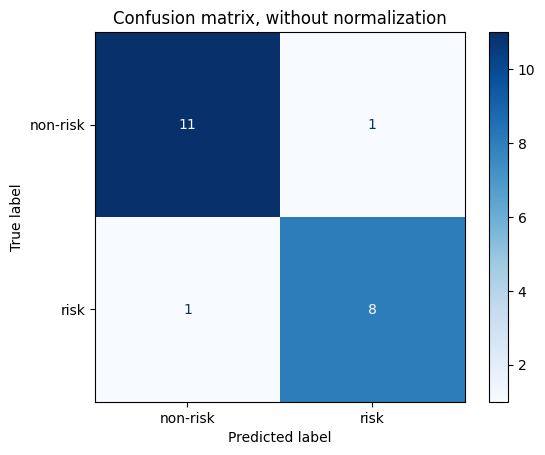

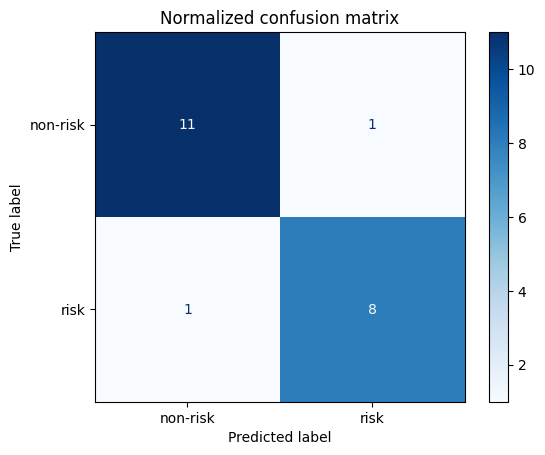

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=['non-risk', 'risk'],
        cmap=plt.cm.Blues,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Evaluation

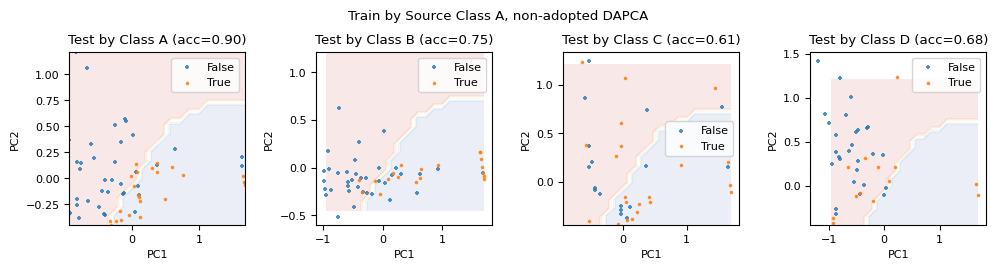

In [32]:
# prepare for contour
resolution = 20
dx = np.linspace(np.min(train_x_pca_np[:, 0]), np.max(train_x_pca_np[:, 0]), resolution)
dy = np.linspace(np.min(train_x_pca_np[:, 1]), np.max(train_x_pca_np[:, 1]), resolution)

# dx = np.linspace(-2, 2, resolution)
# dy = np.linspace(-2, 2, resolution)
dx, dy = np.meshgrid(dx, dy)

# merge dx, dy to test_x
test_x = np.c_[dx.flatten(), dy.flatten()]
z = clf.predict(test_x)
z = z.reshape(dx.shape)

plt.rcParams.update({'font.size': 8})
plt.subplots(figsize=(10, 2.5))
for i in range(0, 4):
    
    plt.subplot(1, 4, i+1)


    # draw
    plt.contourf(dx, dy, z, alpha=0.1, cmap='RdYlBu')
    
    if i == 0:
        scatter_x = train_pca_pd
        predict_x = X_test
        predict_y = y_test
        label = source_class
    else:
        scatter_x = globals()['test_'+str(i-1)+'_pd']
        predict_x = globals()['test_'+str(i-1)+'_x_pca_np']
        predict_y = globals()['test_'+str(i-1)+'_y']
        label = test_list[i-1]
        
    y_pred = clf.predict(predict_x)
    acc = accuracy_score(predict_y, y_pred)
        

    plt.scatter(x = scatter_x[scatter_x['label']==0][0], 
                y = scatter_x[scatter_x['label']==0][1],
                label = 'False',
                alpha=0.8, marker="+", s=10)

    plt.scatter(x = scatter_x[scatter_x['label']==1][0], 
                y = scatter_x[scatter_x['label']==1][1],
                label = 'True',
                alpha=0.8, marker=".", s=10)
    
    plt.ylabel('PC2')
    plt.xlabel('PC1')
        
    plt.legend()
    plt.title('Test by Class ' + label.upper() +' (acc=' +"{:.2f}".format(acc)+')')
    
plt.tight_layout()
plt.suptitle("Train by Source Class " + source_class.upper() + ', non-adopted DAPCA', y=1.05)
plt.show()